In [6]:
# NOTE: To run the no-cusp condition, un-comment the 2nd code block and comment out the 3rd code block. And then run all the necessary code blocks.


import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
from numba.typed import List
from numba import float64
import numpy as np

# Atomic number for Helium
Z = 2
sample_pts = 60

In [2]:
#NOCUSP CONDITIONED (ANSATZE 1)
'''
# Define the trial wavefunction
@njit
def trial_function(alpha, r, num_particles, dimensions):
    input = 0
    for i in range(num_particles):
        r_norm = 0
        for j in range(dimensions):
            r_norm += r[i,j]**2
        input += np.sqrt(r_norm)
    return np.exp(-alpha * input)
'''

In [7]:
#CUSP CONDITIONED (ANSATZE 2)

@njit
def trial_function(alpha, r, number_particles, dimension):
    input = 0
    for i in range(number_particles):
        r_norm = 0
        for j in range(dimension):
            r_norm += r[i, j] ** 2
        input += np.sqrt(r_norm)

    # Compute the distance between particle 1 and particle 2
    if number_particles >= 2:
        diff = 0
        for j in range(dimension):
            diff += (r[0, j] - r[1, j]) ** 2
        particle_diff = np.sqrt(diff)
    else:
        particle_diff = 0  # No second particle to compare

    return np.exp(-alpha * input + particle_diff/2)

In [8]:
# Laplacian using finite difference

@njit
def local_energy(alpha, r, psi_old, num_particles, dimensions, Z, h=1e-3):
    ke = 0
    pe = 0
    r_forward = np.copy(r)
    r_backward = np.copy(r)
    h2 = 1/(h*h)

    #Kinetic Energy
    for i in range(num_particles):
        for j in range(dimensions):
            r_forward[i,j] += h
            r_backward[i,j] -= h
            psi_fwd = trial_function(alpha, r_forward, num_particles, dimensions)
            psi_bwd = trial_function(alpha, r_backward, num_particles, dimensions)
            ke -= (psi_fwd - 2 * psi_old + psi_bwd)
            r_forward[i,j] -= h
            r_backward[i,j] += h
    ke *= 0.5 *(h2 / psi_old)

    #Potential Energy

    for i in range(num_particles):
        r_norm = 0
        for j in range(dimensions):
            r_norm += r[i,j]**2
        pe -= Z/np.sqrt(r_norm)

    for i in range(num_particles - 1):
        for j in range(i + 1, num_particles):
            r_12 = 0
            for k in range(dimensions):
                r_12 += (r[i,k] - r[j,k]) ** 2
            pe += 1 / np.sqrt(r_12)

    return ke + pe

In [4]:
#RUN THIS CODE BLOCK FOR NO-CUSP ANSATZE

#Monte Carlo function for thermalization and MC steps

@njit
def mc_sampling_nocusp(dimensions, num_particles, step_size, th_limit, mc_limit):
    r_new = np.zeros((num_particles, dimensions))
    r_old = np.zeros((num_particles, dimensions))
    E_arr = []
    Var_arr = []
    alpha_values = []

    alpha = 0.5
    for iter_values in range(sample_pts):
        alpha += 0.025
        alpha_values.append(alpha)
        ener = 0
        ener2 = 0

        for i in range(num_particles):
            for j in range(dimensions):
                r_old[i,j] = step_size*(np.random.rand() - 0.5)
        psi_old = trial_function(alpha, r_old, num_particles, dimensions)

        for iter in range(1,mc_limit + th_limit + 1):
            for i in range(num_particles):
                for j in range(dimensions):
                    r_new[i,j] = r_old[i,j] + step_size*(np.random.rand() - 0.5)
            psi_new = trial_function(alpha, r_new, num_particles, dimensions)

            if np.random.rand() <= (psi_new**2)/(psi_old**2):
                r_old = np.copy(r_new)
                psi_old = psi_new

            if iter > th_limit:
                dE = local_energy(alpha, r_old, psi_old, num_particles, dimensions, Z)
                ener += dE
                ener2 += dE**2

        E_arr.append(ener/mc_limit)
        Var_arr.append(ener2/mc_limit)

    return E_arr, Var_arr, alpha_values

The groundstate energy of He Atom in NO CUSP condition is -2.849 (units) at the alpha value = 1.725


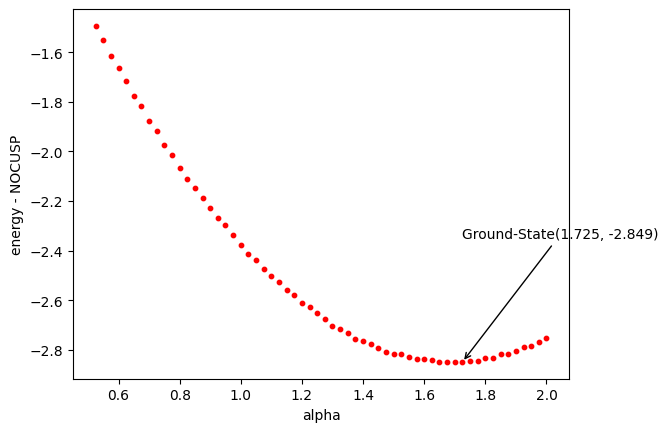

In [5]:
#RUN THIS CODE BLOCK FOR NO-CUSP ANSATZE

#Main Code

mc_limit = 1000000
th_limit = 1000000
num_particles = 2
dimensions = 3
step_size = 1

E_arr_nocusp, Var_arr_nocusp, alpha_arr_nocusp =  mc_sampling_nocusp(dimensions, num_particles, step_size, th_limit, mc_limit)

gs_E = round(min(E_arr_nocusp),3)
gs_Alpha = round(alpha_arr_nocusp[E_arr_nocusp.index(min(E_arr_nocusp))],3)

print(f"The groundstate energy of He Atom in NO CUSP condition is {gs_E} (units) at the alpha value = {gs_Alpha}")

plt.xlabel("alpha")
plt.ylabel("energy - NOCUSP")
plt.annotate(f'Ground-State({gs_Alpha}, {gs_E})',  # Text to display (coordinates)
            xy=(gs_Alpha, gs_E),  # Coordinates of the point to annotate
            xytext=(gs_Alpha, gs_E + 0.5),  # Coordinates of the text
            arrowprops=dict(arrowstyle='->'))  # Optional: add an arrow
plt.scatter(alpha_arr_nocusp, E_arr_nocusp, s=10, marker='o', color='red')

In [ ]:
#RUN THIS CODE BLOCK FOR NO-CUSP ANSATZE

#TABLE

columns = ['Variational Parameter, alpha', 'Energy, E', 'Variance Of Energy']
table_data = np.stack((alpha_arr_nocusp[::4], E_arr_nocusp[::4], Var_arr_nocusp[::4]), axis=1)
table_data = np.round(table_data, decimals = 5)

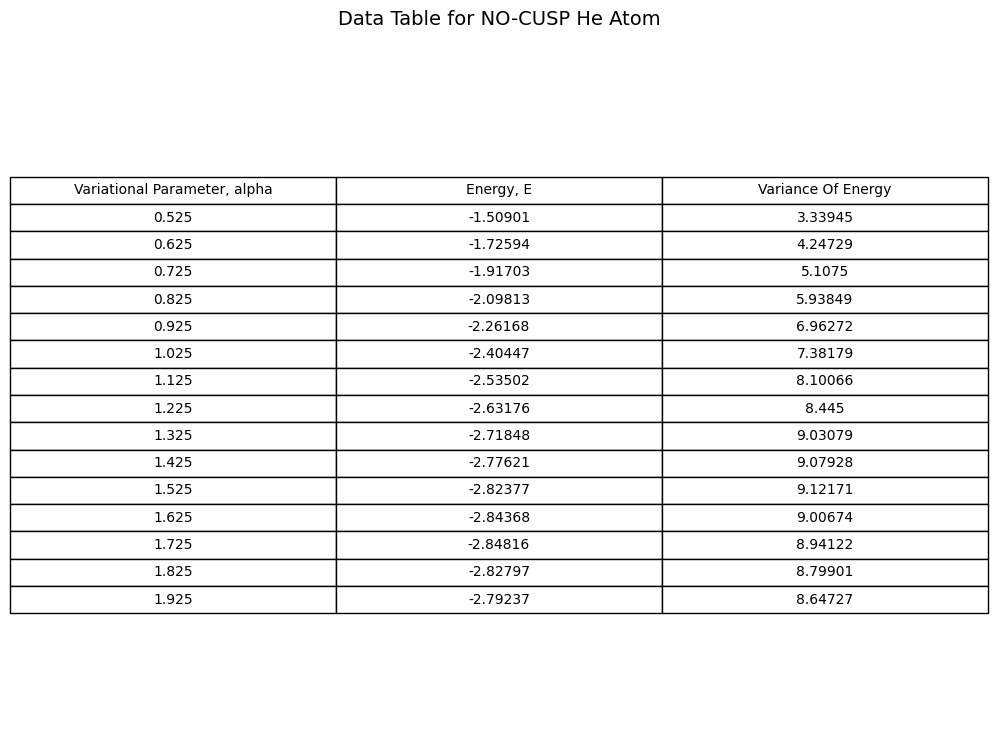

In [ ]:
#RUN THIS CODE BLOCK FOR NO-CUSP ANSATZE

fig, ax = plt.subplots(figsize=(10, 8))

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

table = ax.table(cellText=table_data, colLabels=columns, loc='center', cellLoc='center')

table.auto_set_font_size(True)

table.scale(1.2, 1.5)

fig.suptitle('Data Table for NO-CUSP He Atom', fontsize=14, y=0.95)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [9]:
#RUN THIS CODE BLOCK FOR CUSP ANSATZE

#Monte Carlo function for thermalization and MC steps

@njit
def mc_sampling_cusp(dimensions, num_particles, step_size, th_limit, mc_limit):
    r_new = np.zeros((num_particles, dimensions))
    r_old = np.zeros((num_particles, dimensions))
    E_arr = []
    Var_arr = []
    alpha_values = []

    alpha = 0.5
    for iter_values in range(sample_pts):
        alpha += 0.025
        alpha_values.append(alpha)
        ener = 0
        ener2 = 0

        for i in range(num_particles):
            for j in range(dimensions):
                r_old[i,j] = step_size*(np.random.rand() - 0.5)
        psi_old = trial_function(alpha, r_old, num_particles, dimensions)

        for iter in range(1,mc_limit + th_limit + 1):
            for i in range(num_particles):
                for j in range(dimensions):
                    r_new[i,j] = r_old[i,j] + step_size*(np.random.rand() - 0.5)
            psi_new = trial_function(alpha, r_new, num_particles, dimensions)

            if np.random.rand() <= (psi_new**2)/(psi_old**2):
                r_old = np.copy(r_new)
                psi_old = psi_new

            if iter > th_limit:
                dE = local_energy(alpha, r_old, psi_old, num_particles, dimensions, Z)
                ener += dE
                ener2 += dE**2

        E_arr.append(ener/mc_limit)
        Var_arr.append(ener2/mc_limit)

    return E_arr, Var_arr, alpha_values

The groundstate energy of He Atom in NO CUSP condition is -2.857 (units) at the alpha value = 1.975


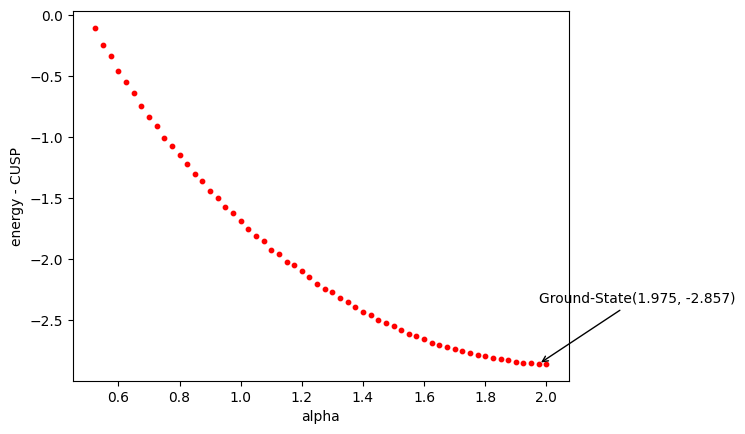

In [10]:
#RUN THIS CODE BLOCK FOR CUSP ANSATZE

#Main Code

mc_limit = 1000000
th_limit = 1000000
num_particles = 2
dimensions = 3
step_size = 1

E_arr_cusp, Var_arr_cusp, alpha_arr_cusp =  mc_sampling_cusp(dimensions, num_particles, step_size, th_limit, mc_limit)

gs_E_c = round(min(E_arr_cusp),3)
gs_Alpha_c = round(alpha_arr_cusp[E_arr_cusp.index(min(E_arr_cusp))],3)

print(f"The groundstate energy of He Atom in NO CUSP condition is {gs_E_c} (units) at the alpha value = {gs_Alpha_c}")

plt.xlabel("alpha")
plt.ylabel("energy - CUSP")

plt.annotate(f'Ground-State({gs_Alpha_c}, {gs_E_c})',
            xy=(gs_Alpha_c, gs_E_c),
            xytext=(gs_Alpha_c, gs_E_c + 0.5),
            arrowprops=dict(arrowstyle='->'))

plt.scatter(alpha_arr_cusp, E_arr_cusp, s=10, marker='o', color='red')


In [11]:
#RUN THIS CODE BLOCK FOR CUSP ANSATZE

#TABLE
columns = ['Variational Parameter, alpha', 'Energy, E', 'Variance Of Energy']
table_data = np.stack((alpha_arr_cusp[::4], E_arr_cusp[::4], Var_arr_cusp[::4]), axis=1)
table_data = np.round(table_data, decimals = 5)

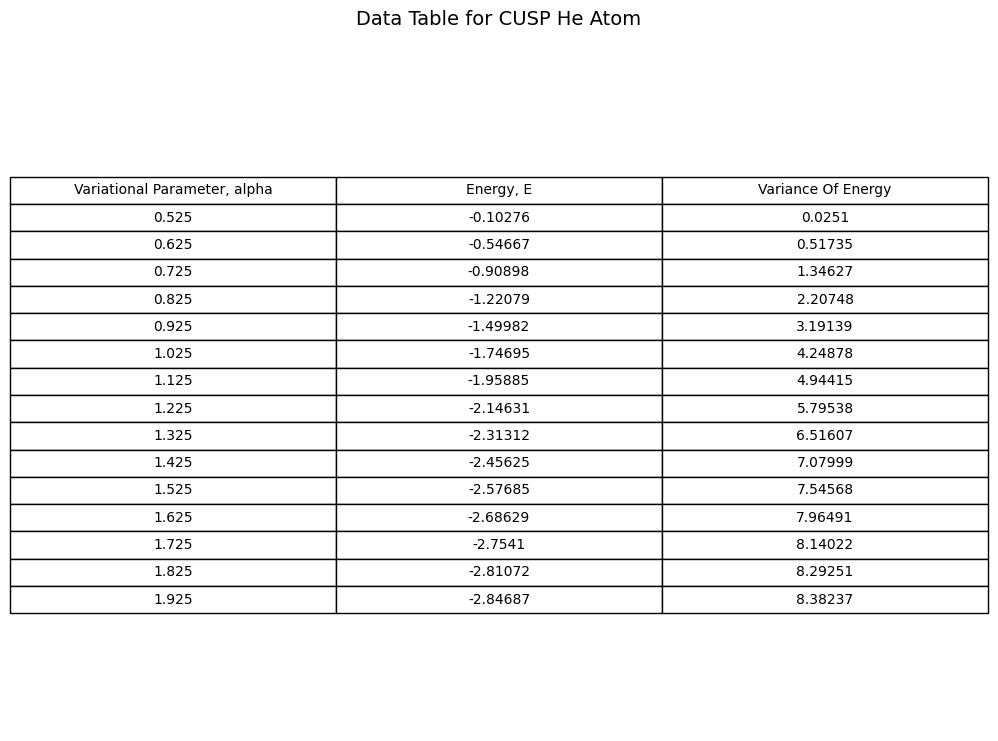

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

table = ax.table(cellText=table_data, colLabels=columns, loc='center', cellLoc='center')

table.auto_set_font_size(True)

table.scale(1.2, 1.5)

fig.suptitle('Data Table for CUSP He Atom', fontsize=14, y=0.95)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()